In [38]:
import xarray as xr
import ODLintake
import hvplot.xarray
import hvplot.pandas
import pandas as pd
import numpy as np
from dask.distributed import Client
from matplotlib import pyplot as plt
import holoviews as hv

plt.rcParams.update({
    'text.usetex':True,
    'font.family':'serif',
    'font.size':18
})

import seaborn as sns
# set the theme
sns.set_palette('inferno', 4)


In [2]:
client = Client()
client

/home/jhrag/anaconda3/envs/ooi_dev/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37457 instead
  warnings.warn(
2023-04-21 17:21:22,429 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-795bj4p0', purging
2023-04-21 17:21:22,430 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-_8rko07z', purging
2023-04-21 17:21:22,430 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-k3zbsqvc', purging
2023-04-21 17:21:22,431 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-3mxrsxv7', purging
2023-04-21 17:21:22,431 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-it7dt66b', purging
2023-04-21 17:21:22,431 - distributed.diskutils

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37457/status,
Dashboard: http://127.0.0.1:37457/status,Workers: 8
Total threads: 32,Total memory: 62.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40137,Workers: 8
Dashboard: http://127.0.0.1:37457/status,Total threads: 32
Started: Just now,Total memory: 62.80 GiB
Comm: tcp://127.0.0.1:36719,Total threads: 4
Dashboard: http://127.0.0.1:45587/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:41267,


### Get Metadata from h5 file

In [27]:
import h5py
import fsspec
import zarr
import kerchunk
import os

# Set the account name, container name, and file path
account_name = "dasdata"
container_name = "hdf5"
account_key = os.environ['AZURE_KEY_dasdata']
file_path = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.h5"


# Set the blob URL using the fsspec AzureBlobFileSystem
blob_url = f"az://{container_name}/{file_path}"

fs = fsspec.filesystem("az", account_name=account_name, account_key=account_key)
blob_stream = fs.open(blob_url)

f = h5py.File(blob_stream)

Task exception was never retrieved
future: <Task finished name='Task-15097' coro=<Client._gather.<locals>.wait() done, defined at /home/jhrag/anaconda3/envs/ooi_dev/lib/python3.10/site-packages/distributed/client.py:2054> exception=AllExit()>
Traceback (most recent call last):
  File "/home/jhrag/anaconda3/envs/ooi_dev/lib/python3.10/site-packages/distributed/client.py", line 2063, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-15098' coro=<Client._gather.<locals>.wait() done, defined at /home/jhrag/anaconda3/envs/ooi_dev/lib/python3.10/site-packages/distributed/client.py:2054> exception=AllExit()>
Traceback (most recent call last):
  File "/home/jhrag/anaconda3/envs/ooi_dev/lib/python3.10/site-packages/distributed/client.py", line 2063, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-15099' coro=<Client._gather.<locals>.wait() done, d

In [28]:
def print_h5_objects(item, level=0):
    """
    Recursively prints the names and types of objects in an HDF5 file.
    """
    indent = ' ' * 4 * level
    print(f"{indent}{item.name} ({type(item)})")

    if isinstance(item, h5py.Group):
        for subitem in item.values():
            print_h5_objects(subitem, level + 1)
    elif isinstance(item, h5py.Dataset):
        print(f"{indent}  dtype: {item.dtype}")
        print(f"{indent}  shape: {item.shape}")
        if item.chunks is not None:
            print(f"{indent}  chunked: yes")
            print(f"{indent}  chunks: {item.chunks}")
        else:
            print(f"{indent}  chunked: no")

        for key, value in item.attrs.items():
            print(f"{indent}  {key}: {value}")

In [116]:
def print_metadata(f):
    """
    This function takes an already opened h5py.File object and prints out the metadata in the file.
    """
    print("Metadata in the h5 file:")
    print("========================")
    for key, value in f.attrs.items():
        print(f"{key}: {value}")

    for group_name, group in f.items():
        print(f"\nGroup name: {group_name}")
        print("--------------------")
        for key, value in group.attrs.items():
            print(f"{key}: {value}")


In [117]:
print_metadata(f)

Metadata in the h5 file:
uuid: b'6b5fbdc4-ec25-4ecb-b5c6-b20138e155d0'

Group name: Acquisition
--------------------
AcquisitionId: b'55e16fd1-ecc9-49d6-962a-ab72c3f3b030'
GaugeLength: 51.0476188659668
GaugeLengthUnit: b'm'
MaximumFrequency: 100.0
MinimumFrequency: 0.0
NumberOfLoci: 47500
PulseRate: 1000.0
PulseWidth: 250.0
PulseWidthUnit: b'ns'
SpatialSamplingInterval: 2.0419046878814697
SpatialSamplingIntervalUnit: b'm'
StartLocusIndex: 0
TriggeredMeasurement: b'false'
VendorCode: b'OptaSense IU Setup 1.7.3 c5bde49175ee6dc70c95d4b39db648d3fda54a46'
schemaVersion: b'2.0'
uuid: b'55e16fd1-ecc9-49d6-962a-ab72c3f3b030'


In [118]:
del_d = f['Acquisition'].attrs['SpatialSamplingInterval'] #m

### Plot Octave Band spectral levels

In [16]:
fn = '/datadrive/DAS/psd_hour.nc'
ds = xr.open_dataset(fn)

In [17]:
ds.load()

<xarray.Dataset>
Dimensions:    (distance: 47500, frequency: 513, time: 55)
Coordinates:
  * time       (time) datetime64[ns] 2021-11-01T23:11:14.834000 ... 2021-11-0...
  * distance   (distance) int64 0 1 2 3 4 5 ... 47495 47496 47497 47498 47499
  * frequency  (frequency) float64 0.0 0.1953 0.3906 0.5859 ... 99.61 99.8 100.0
Data variables:
    psd        (distance, frequency, time) float64 3.416e+09 4.55e+09 ... 0.7427

In [18]:
# octave bands

def onethird_octave(fcenter):
    fd = 10**0.05
    fupper = fcenter * fd
    flower = fcenter / fd
    
    return slice(flower, fupper)

In [19]:
onethird_octave(1)

slice(0.8912509381337456, 1.1220184543019633, None)

In [21]:
octave_1 = ds.loc[{'frequency':onethird_octave(1)}].mean('frequency')['psd']
octave_5 = ds.loc[{'frequency':onethird_octave(5)}].mean('frequency')['psd']
octave_20 = ds.loc[{'frequency':onethird_octave(20)}].mean('frequency')['psd']
octave_50 = ds.loc[{'frequency':onethird_octave(50)}].mean('frequency')['psd']

In [22]:
geo = pd.read_csv('/datadrive/DAS/south_DAS_latlondepth.txt')
depth_plot = geo.hvplot(x='index', y='depth', height=200, width=700, grid=True, c='k', s=1, xlabel='distance index', ylabel='depth [m]')

In [23]:
np.array(geo['index'])[-1]

47381.0

In [24]:
mean1 = 10*np.log10(octave_1.mean('time'))
std1 = (10*np.log10(octave_1)).std('time')

mean5 = 10*np.log10(octave_5.mean('time'))
std5 = (10*np.log10(octave_5)).std('time')

mean20 = 10*np.log10(octave_20.mean('time'))
std20 = (10*np.log10(octave_20)).std('time')

mean50 = 10*np.log10(octave_50.mean('time'))
std50 = (10*np.log10(octave_50)).std('time')

means = [mean1, mean5, mean20, mean50]
stds = [std1, std5, std20, std50]

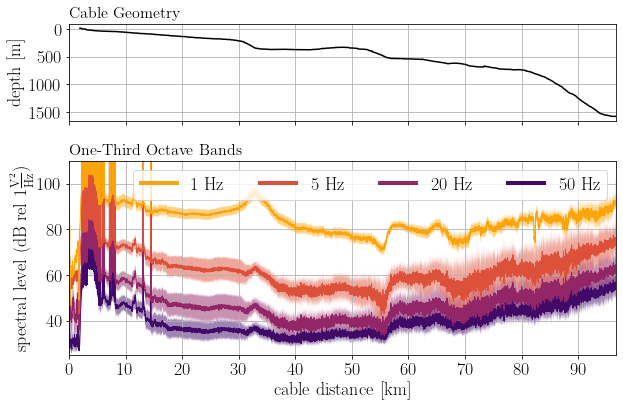

In [115]:
octave_bands = [1,5,20,50]

del_d = 2.0419046878814697 #m

fig, axes = plt.subplots(2,1,figsize=(9,6), gridspec_kw={'height_ratios': [1, 2]})
axes = axes.flatten()

plt.sca(axes[0])
plt.title('Cable Geometry', fontsize=16, loc='left', fontfamily='sans-serif')
plt.plot(del_d*geo['index']/1000, -1*geo['depth'], c='k')
plt.grid()
plt.ylabel('depth [m]')
plt.xticks(np.arange(0,100,10))
plt.xlim([del_d*geo['index'][0]/1000, del_d*np.array(geo['index'])[-1]/1000])
axes[0].set_xticklabels([])
axes[0].set_xticks(np.arange(0,100,10))
axes[0].set_yticks(np.arange(0,2000, 500))
axes[0].invert_yaxis()

plt.sca(axes[1])
plt.title('One-Third Octave Bands', fontsize=16, loc='left', fontfamily='sans-serif')
for k in range(3,-1,-1):
    plt.plot(means[k].distance*del_d/1000, means[k], linewidth=1, label=f'{octave_bands[k]} Hz')
    plt.fill_between(stds[k].distance*del_d/1000, means[k]-3*stds[k]/2, means[k]+3*stds[k]/2, alpha=0.5)
    
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [3,2,1,0]

legend = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper right', ncol=4)

for line in legend.get_lines():
    line.set_linewidth(4)

plt.xlim([del_d*geo['index'][0]/1000, del_d*np.array(geo['index'])[-1]/1000])
plt.grid()
plt.ylim((25,110))
plt.ylabel(r'spectral level (dB rel $1 \mathrm{\frac{V^2}{Hz}}$)')
plt.xlabel('cable distance [km]')
plt.xticks(np.arange(0,100,10))

plt.tight_layout()

fig.savefig('figures/psd_octave_band_geometry.png', dpi=300)

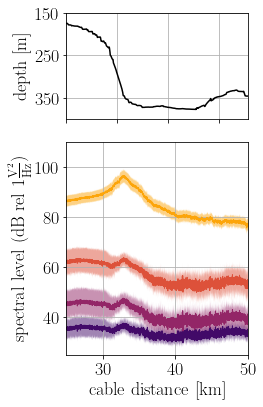

In [117]:
octave_bands = [1,5,20,50]

del_d = 2.0419046878814697 #m

fig, axes = plt.subplots(2,1,figsize=(4,6), gridspec_kw={'height_ratios': [1, 2]})
axes = axes.flatten()

plt.sca(axes[0])
#plt.title('Cable Geometry', fontsize=16, loc='left', fontfamily='sans-serif')
plt.plot(del_d*geo['index']/1000, -1*geo['depth'], c='k')
plt.grid()
plt.ylabel('depth [m]')
plt.xticks(np.arange(0,100,10))
plt.xlim([25, 50])
plt.ylim([150,400])
axes[0].set_xticklabels([])
axes[0].set_xticks(np.arange(25,50,7))
axes[0].set_yticks(np.arange(150,400,100))
axes[0].invert_yaxis()

plt.sca(axes[1])
#plt.title('One-Third Octave Bands', fontsize=16, loc='left', fontfamily='sans-serif')
for k in range(3,-1,-1):
    plt.plot(means[k].distance*del_d/1000, means[k], linewidth=1, label=f'{octave_bands[k]} Hz')
    plt.fill_between(stds[k].distance*del_d/1000, means[k]-3*stds[k]/2, means[k]+3*stds[k]/2, alpha=0.5)
    
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [3,2,1,0]

#legend = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper right', ncol=4)

#for line in legend.get_lines():
#line.set_linewidth(4)

plt.xlim([25, 50])
plt.grid()
plt.ylim((25,110))
plt.ylabel(r'spectral level (dB rel $1 \mathrm{\frac{V^2}{Hz}}$)')
plt.xlabel('cable distance [km]')
#plt.xticks(np.arange(0,100,10))

plt.tight_layout()

fig.savefig('figures/psd_octave_band_geometry_zoomed_25_50km.png', dpi=300)

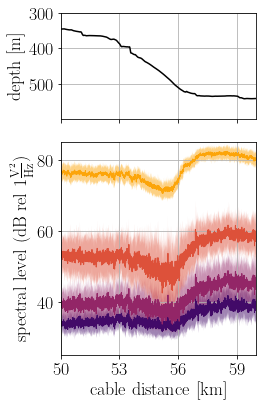

In [122]:
octave_bands = [1,5,20,50]

del_d = 2.0419046878814697 #m

fig, axes = plt.subplots(2,1,figsize=(4,6), gridspec_kw={'height_ratios': [1, 2]})
axes = axes.flatten()

plt.sca(axes[0])
#plt.title('Cable Geometry', fontsize=16, loc='left', fontfamily='sans-serif')
plt.plot(del_d*geo['index']/1000, -1*geo['depth'], c='k')
plt.grid()
plt.ylabel('depth [m]')

plt.xlim([50, 60])
plt.ylim([300,600])
axes[0].set_xticklabels([])
axes[0].set_xticks(np.arange(50,60,3))
axes[0].set_yticks(np.arange(300,600,100))
axes[0].invert_yaxis()

plt.sca(axes[1])
#plt.title('One-Third Octave Bands', fontsize=16, loc='left', fontfamily='sans-serif')
for k in range(3,-1,-1):
    plt.plot(means[k].distance*del_d/1000, means[k], linewidth=1, label=f'{octave_bands[k]} Hz')
    plt.fill_between(stds[k].distance*del_d/1000, means[k]-3*stds[k]/2, means[k]+3*stds[k]/2, alpha=0.5)
    
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [3,2,1,0]

#legend = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper right', ncol=4)

#for line in legend.get_lines():
#line.set_linewidth(4)

plt.xlim([50, 60])
axes[1].set_xticks(np.arange(50,60,3))
plt.grid()
plt.ylim((25,85))
plt.ylabel(r'spectral level (dB rel $1 \mathrm{\frac{V^2}{Hz}}$)')
plt.xlabel('cable distance [km]')
#plt.xticks(np.arange(0,100,10))

plt.tight_layout()

fig.savefig('figures/psd_octave_band_geometry_zoomed_50_60km.png', dpi=300)

## Play with Seaborne

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [11]:
plt.rcParams.update({
    'text.usetex':True,
    'font.family':'serif'
})

In [24]:
# set the theme
sns.set_palette('copper', 15)

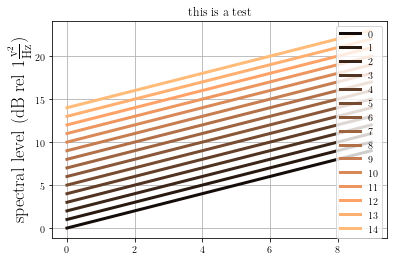

In [25]:
for k in range(15):
    plt.plot(np.arange(k, k+10, 1), linewidth=3, label=k)
plt.grid()
plt.title('this is a test')
plt.ylabel(r'spectral level (dB rel $1 \mathrm{\frac{v^2}{Hz}}$)', fontsize=18)
plt.legend()

In [16]:
from matplotlib import pyplot as plt
import seaborne as sns

ModuleNotFoundError: No module named 'seaborne'